In [1]:
# !pip install --disable-pip-version-check -q --upgrade pip
# !pip install --disable-pip-version-check -q imblearn
# !pip install --disable-pip-version-check -q scikit-plot
# !pip install --disable-pip-version-check -q --upgrade boto3
# !pip install --disable-pip-version-check -q sagemaker==2.29.2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('./data/winequality-red.csv')
df.dropna(inplace=True)

df.shape #(1599, 11)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Data exploration

### Correlation Analysis

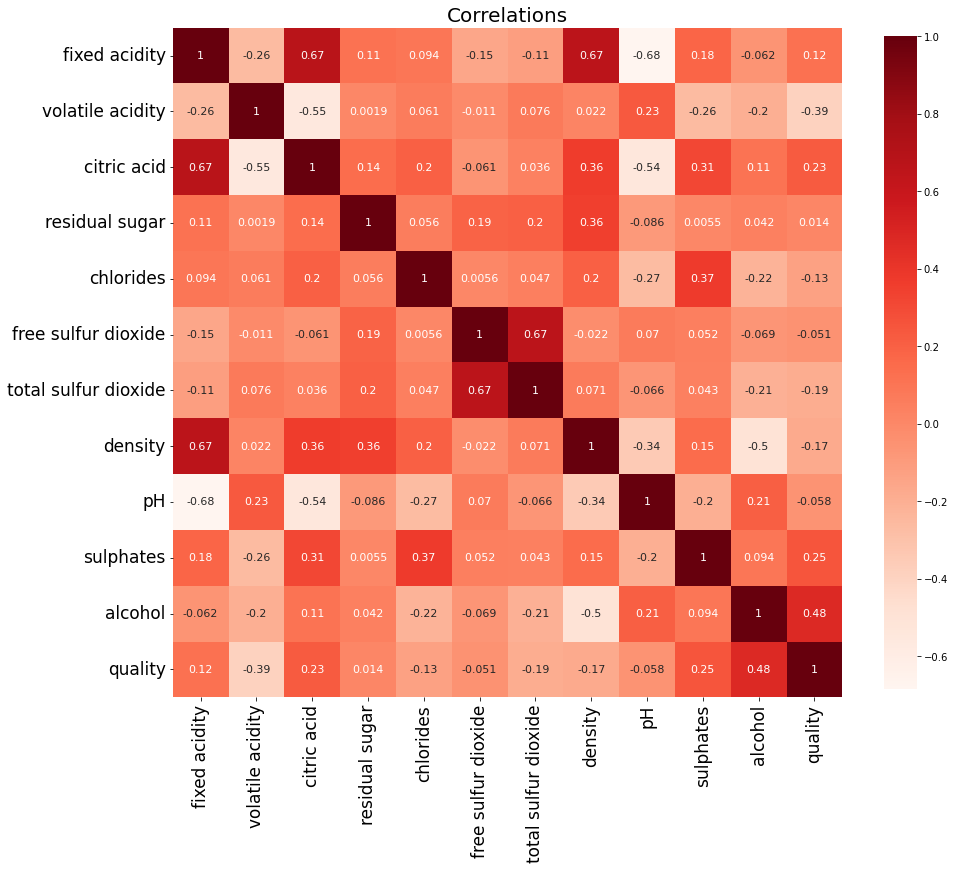

In [4]:
plt.figure(figsize = (15, 15))
sns.heatmap(df.corr(), cmap='Reds', square=True,
            annot=True, annot_kws={'size': 11},
            cbar_kws={'shrink': 0.80})
plt.title("Correlations", size=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

<b>Note:</b> none of correlation > 0.8, keep all data.

### Univariate distribution of data

In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


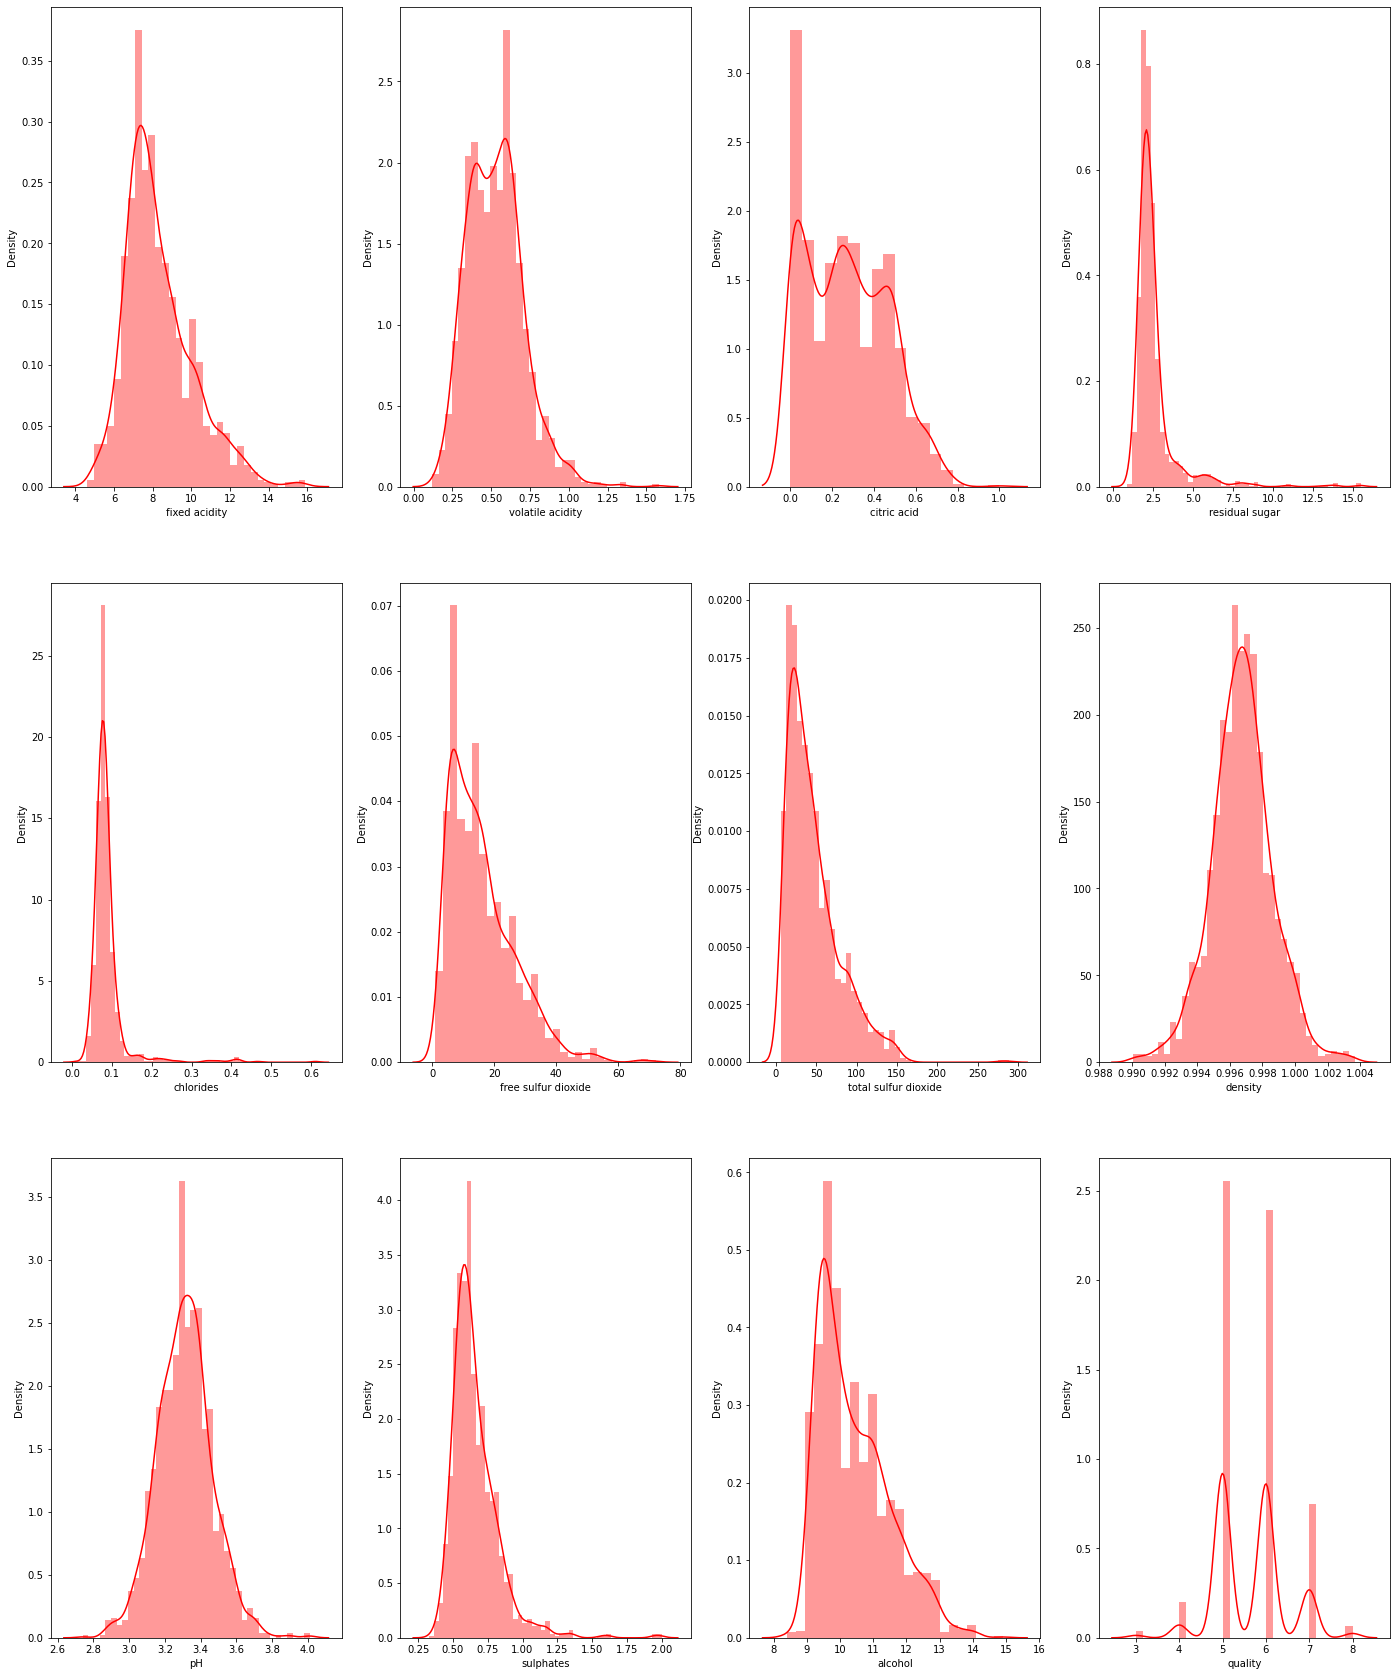

In [6]:
fig, ax1 = plt.subplots(3,4, figsize=(24,30))
k = 0
columns = list(df.columns)
for i in range(3):
    for j in range(4):
            sns.distplot(df[columns[k]], ax=ax1[i][j], color='red')
            k += 1
plt.show()

<b>Note:</b> some of the columns are highly skewed towards the left, therefore, we need to apply log transform to solve this problem.

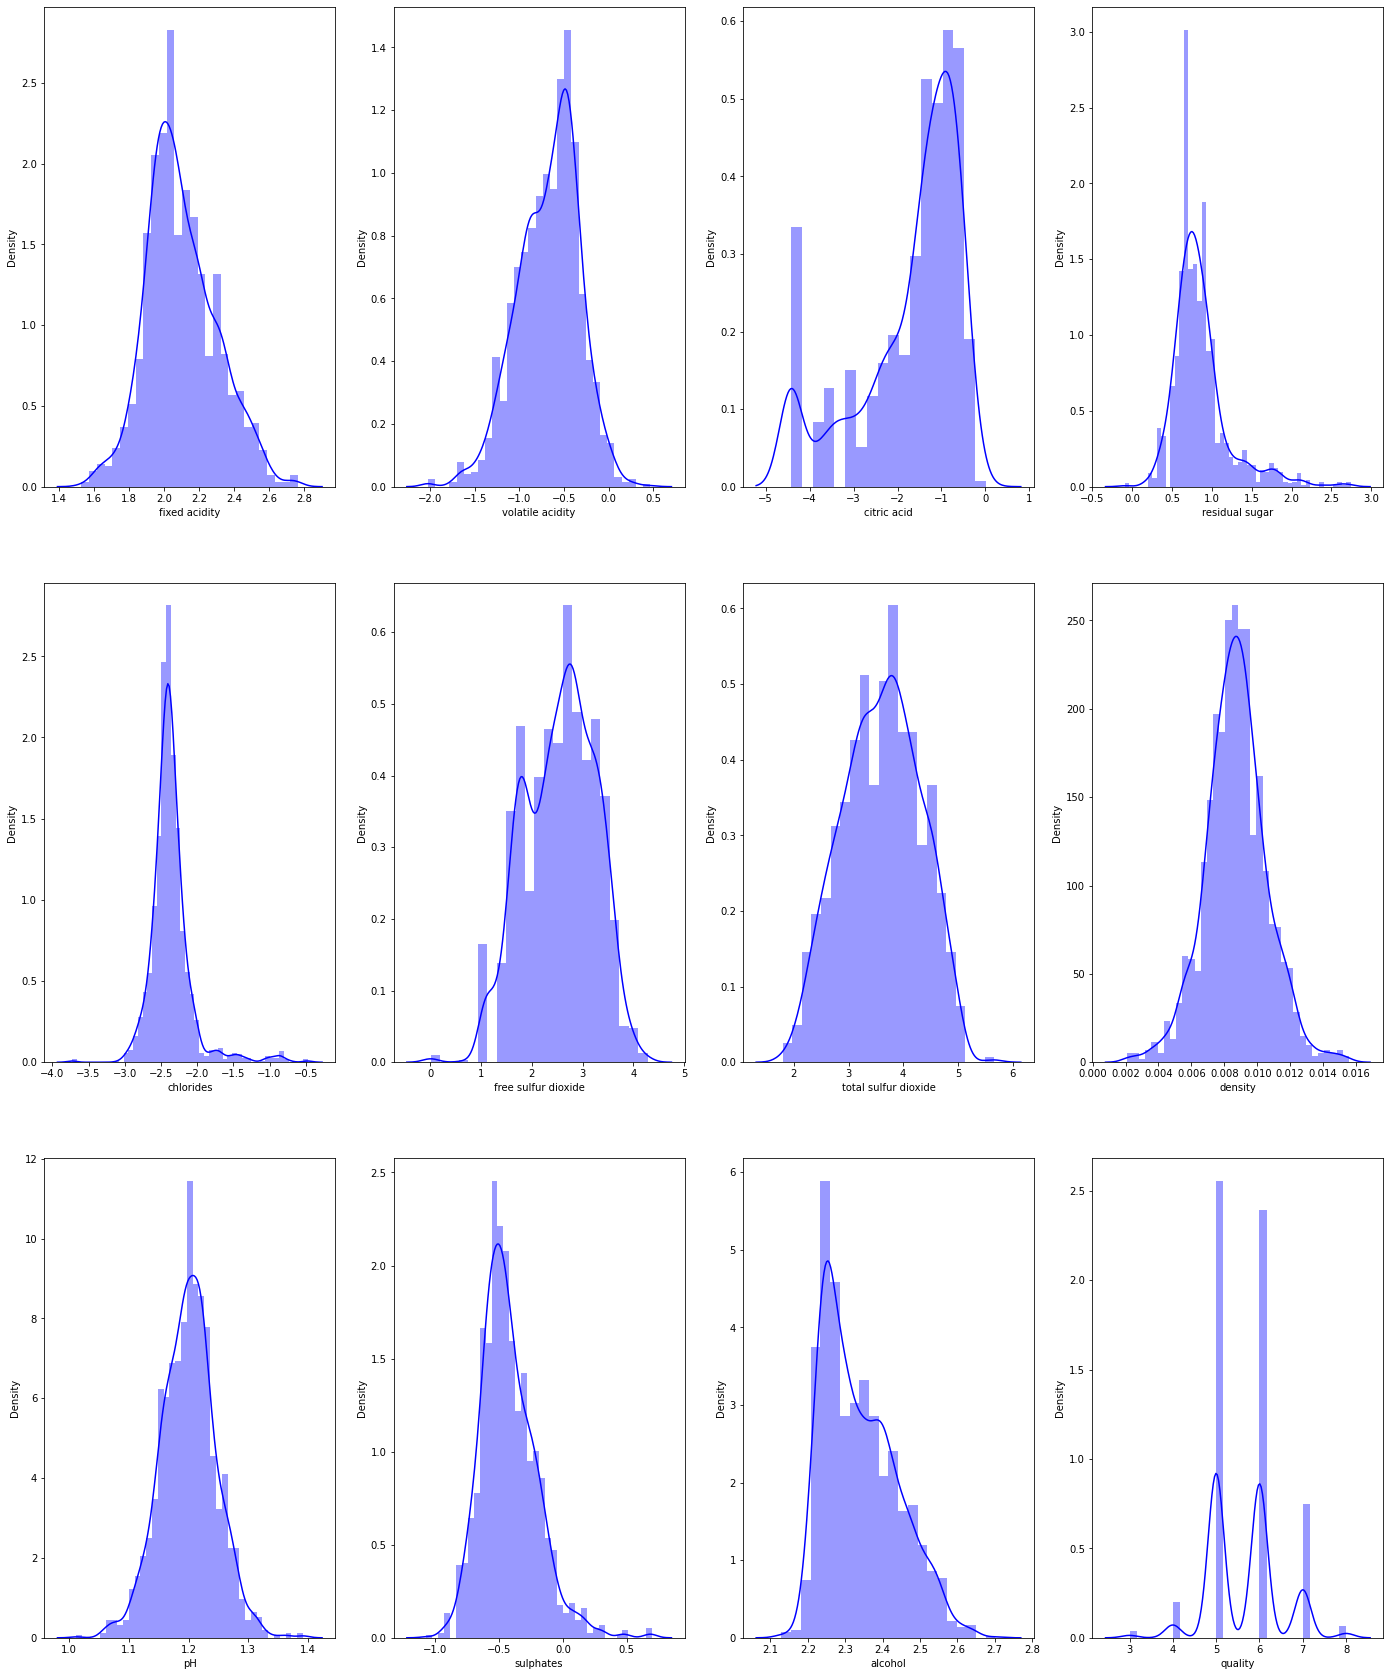

In [7]:
# Log transform
j = 0
for i in range(11):
    df[columns[j]] = np.log(df[columns[j]]+0.012) # log(x+c) to avoid log(0)
    j += 1

# Plot data after log transform
fig, ax1 = plt.subplots(3,4, figsize=(24,30))
k = 0
columns = list(df.columns)
for i in range(3):
    for j in range(4):
            sns.distplot(df[columns[k]], ax=ax1[i][j], color='blue')
            k += 1
plt.show()

### Imbalance check

<AxesSubplot:xlabel='quality', ylabel='count'>

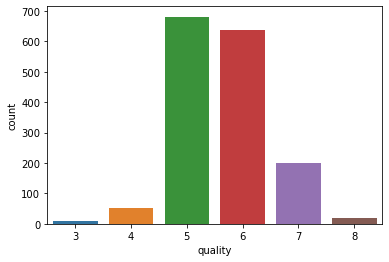

In [8]:
sns.countplot(data=df, x='quality')

<b>Note:</b> Since the samples with quality 3, 4, 7, and 8 are not enough for training, we use over-sampling instead of under-sampling to deal with this imbalanced data.

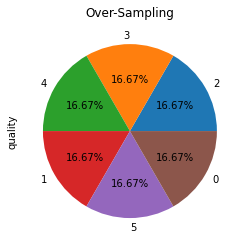

In [9]:
X = df.drop(columns=['quality'])
y = df['quality'] - 3 #-3: Because XGBoost's SoftmaxMultiClassObj: label must be in [0, num_class).

ros = RandomOverSampler()
X_balanced, y_balanced = ros.fit_resample(X, y)

ax = y_balanced.value_counts().plot.pie(autopct='%.2f%%')
_ = ax.set_title('Over-Sampling')

# Training Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

train = pd.concat([pd.Series(y_train, index=X_train.index, dtype=int), X_train], axis=1)
validation = pd.concat([pd.Series(y_val, index=X_val.index, dtype=int), X_val], axis=1)
test = pd.concat([pd.Series(y_test, index=X_test.index, dtype=int), X_test], axis=1)

In [11]:
train

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3551,5,2.333308,-1.102620,-0.772190,1.858171,-2.465104,1.611835,2.565872,0.009554,1.176190,-0.183923,2.534649
3645,5,1.706928,-0.689155,-3.170086,0.594431,-2.882404,3.332633,4.466046,0.002796,1.256186,-0.183923,2.639914
1469,0,1.989517,-0.008032,-2.780621,0.747635,-2.617296,2.996332,3.892065,0.009009,1.200567,-0.576253,2.273362
1774,0,1.918686,-0.189951,-4.422849,0.192272,-1.276543,2.773338,3.367710,0.006688,1.203573,-0.650088,2.283606
354,3,1.810254,-1.505078,-0.886732,0.345007,-2.551046,3.701598,5.106018,0.003195,1.182341,-0.507498,2.477546
...,...,...,...,...,...,...,...,...,...,...,...,...
2559,1,1.611835,0.031499,-2.956512,0.345007,-2.864704,3.713865,4.442792,0.005783,1.324951,-0.709277,2.352517
2243,0,2.003100,0.179818,-4.422849,1.449739,-2.216407,1.611835,2.639914,0.008563,1.292533,-0.594207,2.371365
2066,0,2.029726,0.464991,-4.422849,0.747635,-1.903809,1.611835,2.198557,0.006737,1.256186,-0.886732,2.389863
1089,4,2.452039,-0.862750,-0.594207,0.413433,-2.234926,3.091588,3.713865,0.009307,1.109222,-0.258771,2.293746


In [12]:
validation

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3286,4,2.352517,-1.378326,-0.729811,0.747635,-2.551046,1.793757,3.178554,0.009752,1.151205,-0.092115,2.398986
2971,4,1.961783,-0.397497,-4.422849,0.880456,-2.748872,1.793757,2.398986,0.005167,1.212536,-0.397497,2.542546
1713,0,2.342959,-0.474815,-0.689155,0.747635,-1.551169,1.611835,2.773338,0.011336,1.154362,-0.443167,2.129659
2451,1,2.016502,-0.265268,-4.422849,0.648150,-2.343407,1.793757,2.485906,0.008682,1.209557,-0.689155,2.273362
2474,1,2.117700,-0.450986,-1.551169,0.413433,-2.385967,3.296281,4.779224,0.009158,1.154362,0.123986,2.209592
...,...,...,...,...,...,...,...,...,...,...,...,...
1622,0,2.003100,0.179818,-4.422849,1.449739,-2.216407,1.611835,2.639914,0.008563,1.292533,-0.594207,2.371365
424,2,2.042778,-0.028399,-1.551169,0.699129,-2.830218,2.708850,4.094545,0.007472,1.215506,-0.794073,2.389863
2612,1,1.873647,-0.382726,-4.422849,1.461402,-2.673649,2.398986,2.996332,0.006856,1.241846,-0.558616,2.469116
2438,1,1.793757,-1.072945,-1.102620,2.558157,-2.718101,1.793757,4.727494,0.007690,1.197552,-0.558616,2.443390


In [13]:
test

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1607,0,2.117700,0.031499,-3.442019,1.227299,-2.343407,1.793757,2.398986,0.010861,1.250475,-0.689155,2.398986
3409,4,2.283606,-0.669431,-1.044124,0.838113,-2.244316,2.303784,3.806929,0.010584,1.179270,-0.491023,2.273362
1751,0,1.903897,-0.258771,-3.442019,0.594431,-2.407946,1.793757,2.485906,0.007968,1.270322,-0.443167,2.298778
2275,1,2.323563,-1.418818,-0.962335,0.793897,-2.673649,2.639914,3.583852,0.008107,1.176190,-0.689155,2.231304
230,4,1.650964,-0.709277,-2.956512,0.477476,-2.718101,2.945070,4.663552,0.004689,1.267511,-0.458866,2.502419
...,...,...,...,...,...,...,...,...,...,...,...,...
756,3,1.842453,-0.008032,-3.816713,0.699129,-2.673649,2.708850,3.496871,0.006856,1.284262,-0.750776,2.416985
2594,1,1.989517,-1.016111,-1.378326,0.699129,-2.538307,3.332633,3.871451,0.007730,1.236053,-0.594207,2.303784
3974,5,1.706928,-0.689155,-3.170086,0.594431,-2.882404,3.332633,4.466046,0.002796,1.256186,-0.183923,2.639914
968,3,2.198557,-0.886732,-0.816445,0.880456,-2.525729,3.367710,3.828902,0.006280,1.166894,-0.491023,2.502419


### Save train, validation, test data as csv format

In [14]:
train.to_csv('./data/transformed-data/train.csv', index=False)
test.to_csv('./data/transformed-data/test.csv', index=False)
validation.to_csv('./data/transformed-data/validation.csv', index=False)

### Upload data to s3 bucket

In [15]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

print('S3 Bucket: {}'.format(bucket))
print('Region: {}'.format(region))

prefix = 'data'

transformed_data_s3_uri = 's3://{}/{}/transformed-data/'.format(bucket, prefix)

S3 Bucket: sagemaker-eu-central-1-756960466529
Region: eu-central-1


In [16]:
!aws s3 cp --recursive ./data/transformed-data $transformed_data_s3_uri

upload: data/transformed-data/train.csv to s3://sagemaker-eu-central-1-756960466529/data/transformed-data/train.csv
upload: data/transformed-data/validation.csv to s3://sagemaker-eu-central-1-756960466529/data/transformed-data/validation.csv
upload: data/transformed-data/test.csv to s3://sagemaker-eu-central-1-756960466529/data/transformed-data/test.csv


In [17]:
!aws s3 ls --recursive $transformed_data_s3_uri

2023-01-10 00:05:05     175282 data/transformed-data/test.csv
2023-01-10 00:05:05     524853 data/transformed-data/train.csv
2023-01-10 00:05:05     175047 data/transformed-data/validation.csv


### Setup Debugger & Create an estimator instance 

In [18]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'XGBoost_model')

image_uri = sagemaker.image_uris.retrieve(
    region=region,
    framework='xgboost',
    version='1.2-1'
)

xgboost_model = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role, 
    instance_count=2, 
    instance_type='ml.m5.large',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sess,
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)

### Find the best hyperparameters with Automatic Model Tuning

### Configure the hyper-parameters for XGBoost & Train model

In [19]:
xgboost_model.set_hyperparameters(
    num_class=6,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    objective="multi:softmax",
    num_round=1000
)    

In [20]:
train_input = TrainingInput(s3_data="s3://{}/{}/{}".format(bucket, prefix, 'transformed-data/train.csv'),
                            content_type="csv")
validation_input = TrainingInput(s3_data="s3://{}/{}/{}".format(bucket, prefix, 'transformed-data/validation.csv'),
                                 content_type="csv")

In [21]:
xgboost_model.fit({"train": train_input, "validation": validation_input}, wait=True)

2023-01-10 00:05:06 Starting - Starting the training job...
2023-01-10 00:05:32 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport-1673309106: InProgress
.........
2023-01-10 00:07:04 Downloading - Downloading input data
2023-01-10 00:07:04 Training - Downloading the training image.....[2023-01-10 00:07:43.729 ip-10-0-84-254.eu-central-1.compute.internal:6 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimi

In [22]:
rule_output_path = xgboost_model.output_path + "/" + xgboost_model.latest_training_job.job_name + "/rule-output"

In [23]:
! aws s3 ls {rule_output_path} --recursive 

2023-01-10 00:27:08     437147 data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/CreateXgboostReport/xgboost_report.html
2023-01-10 00:27:07     241583 data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/CreateXgboostReport/xgboost_report.ipynb
2023-01-10 00:26:50     322721 data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/ProfilerReport-1673309106/profiler-output/profiler-report.html
2023-01-10 00:26:49     169096 data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/ProfilerReport-1673309106/profiler-output/profiler-report.ipynb
2023-01-10 00:26:46        192 data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/ProfilerReport-1673309106/profiler-output/profiler-reports/BatchSize.json
2023-01-10 00:26:46        200 data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/ProfilerReport-1673309106/profiler-output/profiler-reports/CPUBottleneck.json
2023-01-10 00:26

In [24]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-eu-central-1-756960466529/data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/CreateXgboostReport/xgboost_report.ipynb to CreateXgboostReport/xgboost_report.ipynb
download: s3://sagemaker-eu-central-1-756960466529/data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/ProfilerReport-1673309106/profiler-output/profiler-reports/BatchSize.json to ProfilerReport-1673309106/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-eu-central-1-756960466529/data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/ProfilerReport-1673309106/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport-1673309106/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-eu-central-1-756960466529/data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/rule-output/ProfilerReport-1673309106/profiler-output/profiler-report.ipynb to ProfilerReport-1673309106/profiler-output/

In [25]:
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/CreateXgboostReport/xgboost_report.html

In [26]:
profiler_report_name = [rule["RuleConfigurationName"] 
                        for rule in xgboost_model.latest_training_job.rule_job_summary() 
                        if "Profiler" in rule["RuleConfigurationName"]][0]
profiler_report_name
display("Click link below to view the profiler report", FileLink(profiler_report_name+"/profiler-output/profiler-report.html"))

'Click link below to view the profiler report'

/home/ec2-user/SageMaker/ProfilerReport-1673309106/profiler-output/profiler-report.html

In [27]:
xgboost_model.model_data

's3://sagemaker-eu-central-1-756960466529/data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/output/model.tar.gz'

# Deploy model

In [28]:
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgboost_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

---------!

In [29]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2023-01-10-00-27-19-349'

# Evaluate model

In [30]:
import numpy as np
def predict(data, rows=1000):
#     import ipdb; ipdb.set_trace()
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

In [31]:
import sklearn

predictions=predict(test.to_numpy()[:,1:])

y_test = test.iloc[:, 0]+3
y_pred = predictions+3

print(sklearn.metrics.confusion_matrix(y_test, y_pred))
print(sklearn.metrics.classification_report(y_test, y_pred))

[[128   0   0   0   0   0]
 [  0 160   0   0   0   0]
 [  2   5 100  24   3   0]
 [  1   2  29  88  19   1]
 [  0   1   3   4 111   0]
 [  0   0   0   0   0 137]]
              precision    recall  f1-score   support

           3       0.98      1.00      0.99       128
           4       0.95      1.00      0.98       160
           5       0.76      0.75      0.75       134
           6       0.76      0.63      0.69       140
           7       0.83      0.93      0.88       119
           8       0.99      1.00      1.00       137

    accuracy                           0.89       818
   macro avg       0.88      0.88      0.88       818
weighted avg       0.88      0.89      0.88       818

